# Convolutionnal Neural Network (CNN) Model for preventing ArUco tag occlusion

* #### author: Mowibox (Ousmane THIONGANE)
* #### date: December 29th, 2024

### Imports

In [39]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MSE
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten

## Dataset preparation 

In [40]:
filepath = r'dataset/dataset.csv'
df = pd.read_csv(filepath, sep=",", header=0).copy()

display(df.head(5))
df.info()

,filename,x20,y20,x21,y21,x22,y22,x23,y23
0,img_0.png,155.50,274.50,417.75,198.75,145.25,403.75,441.25,354.50
1,img_1.png,154.50,278.00,418.25,203.25,144.00,407.75,441.50,361.25
2,img_2.png,307.50,257.25,512.50,206.25,297.50,366.75,516.25,372.25
3,img_3.png,306.75,257.25,518.00,202.50,296.75,367.50,523.50,371.50
4,img_4.png,133.75,244.00,438.00,147.25,131.00,396.00,471.00,366.50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1847 entries, 0 to 1846
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1847 non-null   object 
 1   x20       1847 non-null   float64
 2   y20       1847 non-null   float64
 3   x21       1847 non-null   float64
 4   y21       1847 non-null   float64
 5   x22       1847 non-null   float64
 6   y22       1847 non-null   float64
 7   x23       1847 non-null   float64
 8   y23       1847 non-null   float64
dtypes: float64(8), object(1)
memory usage: 130.0+ KB


In [41]:
WIDTH = 0.6
HEIGHT = 0.6

X, y = [], []
for idx, row in df.iterrows():
    img = cv2.imread(f"dataset/img/{row['filename']}")

    img = cv2.resize(img, (int(img.shape[1]*WIDTH), int(img.shape[0]*HEIGHT)))
    img = img / 255.0 # Data normalization
    X.append(img)

    label = row[1:].values.astype(float)  
    for i in range(0, len(label), 2):
        label[i] *= WIDTH  
        label[i + 1] *= HEIGHT  
    y.append(label)

X = np.array(X)
y = np.array(y)

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (1847, 288, 384, 3)
Labels shape: (1847, 8)


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape)

(1477, 288, 384, 3) (370, 288, 384, 3)


## CNN Model

In [43]:
model_cnn = Sequential()
model_cnn.add(Input(X_train[0].shape))
model_cnn.add(Conv2D(256, (3, 3), strides=2, activation='relu'))
model_cnn.add(MaxPool2D(3, 3))
model_cnn.add(Conv2D(128, (3, 3), strides=2, activation='relu'))
model_cnn.add(MaxPool2D(3, 3))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(8, activation='linear'))

model_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 143, 191, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 47, 63, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 23, 31, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 5, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       163,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 542,248 (2.07 MB)

 Trainable params: 542,248 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

## Training and validation

In [44]:
model_cnn.compile(loss=MSE, optimizer=Adam(learning_rate=0.001), metrics=['mae'])

In [45]:
epochs = 100
history = model_cnn.fit(X_train, y_train,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 599ms/step - loss: 22493.0273 - mae: 121.7500 - val_loss: 1620.8749 - val_mae: 32.5741
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 546ms/step - loss: 1855.9385 - mae: 34.0741 - val_loss: 1342.7406 - val_mae: 29.0896
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 541ms/step - loss: 1449.8224 - mae: 30.5416 - val_loss: 1400.8771 - val_mae: 28.9148
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 543ms/step - loss: 1372.9163 - mae: 29.5441 - val_loss: 1269.8542 - val_mae: 27.7046
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 602ms/step - loss: 1289.7731 - mae: 28.5769 - val_loss: 1118.0542 - val_mae: 26.7667
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 569ms/step - loss: 1269.7103 - mae: 28.2359 - val_loss: 1057.0681 - val_mae: 25.6474
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 546ms/step - loss: 1066.5691 - mae: 25.5466 - val_loss: 953.7399 - val_mae: 24.0765
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 553ms/step - loss: 962.3583 - mae: 24.1939 - val_loss: 1065.

In [46]:
def displayLearningCurve(history, epochs: int, metric: str):
    """
    Displays the model learning curve (training & validation)

    @param history: The model history
    @param epochs: The number of epochs
    @param metric: The evaluated metric
    """
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history[metric])
    plt.plot(epoch_range, history.history[f'val_{metric}'])
    plt.title(f"Model {metric}")
    plt.ylabel(f'{metric}')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='upper right')

    plt.tight_layout()
    plt.show()

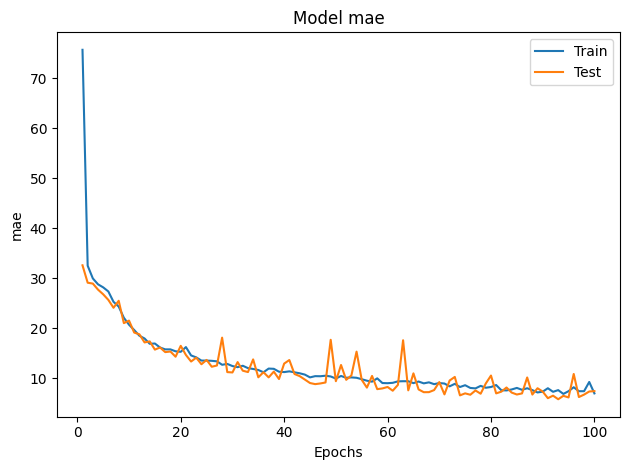

In [47]:
displayLearningCurve(history=history, epochs=epochs, metric='mae')

## Model visualisation

In [48]:
def display_img(img: np.ndarray, real_points: np.ndarray=[], predicted_points: np.ndarray=[]):
    """
    Displays the provided image on a plot
    Allows to compare real points between model prediction 

    @param img: The input image
    @param real_points: The center coordinates of the markers
    @param predicted_points: The predicted center coordinates
    """
    img =  (img*255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    for i in range(0, len(real_points), 2):  
        xr, yr = real_points[i], real_points[i + 1]
        ax.scatter(xr, yr, color='cyan', label='Real Points' if i == 0 else "")

    for i in range(0, len(predicted_points), 2):  
        xp, yp = predicted_points[i], predicted_points[i + 1]
        ax.scatter(xp, yp, color='red', marker='x', s=100, label='Predicted Points' if i == 0 else "")
        ax.set_title("Model prediction vs real values")
    ax.legend()
    ax.imshow(img)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


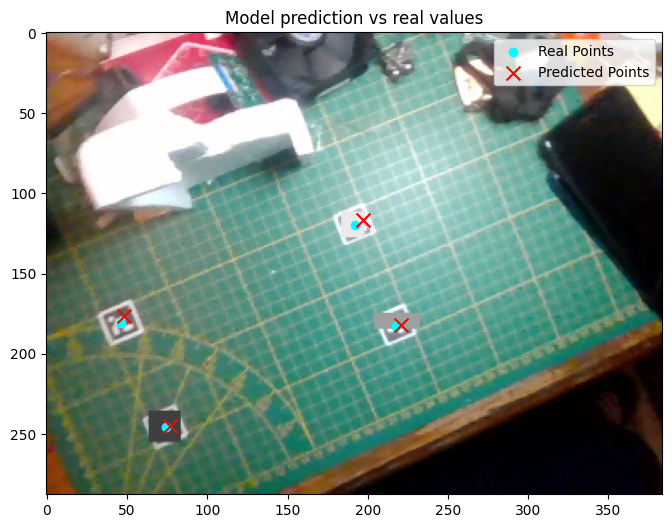

In [49]:
index = np.random.randint(0,1000)

row = df.iloc[index]
filepath = f"dataset/img/{row['filename']}"
img = cv2.imread(filepath)
img = cv2.resize(img, (int(img.shape[1]*WIDTH), int(img.shape[0]*HEIGHT)))
img = img / 255.0

real_points = row[1:].values.astype(float)  
for i in range(0, len(real_points), 2):
    real_points[i] *= WIDTH  
    real_points[i + 1] *= HEIGHT  

predicted_points = model_cnn.predict(np.expand_dims(img, axis=0))[0]

display_img(img, real_points, predicted_points)

## Saving model

In [50]:
#model_cnn.save(filepath=f'cnn_model.keras')